<a href="https://colab.research.google.com/github/Rana-Altaify/Alzheimer-s_ML_Model/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import libraries**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras import regularizers

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter

# **Import Data**

In [ ]:
from huggingface_hub import hf_hub_download
import zipfile, os
from tensorflow import keras

repo_id = "r2n2/bestalzheimer"
filename = "alzhemier.zip"

file_path = hf_hub_download(repo_id=repo_id, filename=filename, repo_type="dataset")

extract_dir = "./alz_data"
os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(" Files extracted to:", extract_dir)
print("Folders:", os.listdir(extract_dir))

base_dir = os.path.join(extract_dir, "Combined Dataset")
train_path = os.path.join(base_dir, "train")
test_path = os.path.join(base_dir, "test")

print(" Train Path:", train_path)
print(" Test Path:", test_path)

train_dataset = keras.utils.image_dataset_from_directory(
    directory=train_path,
    labels="inferred",
    label_mode="int",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    color_mode="rgb",
)

test_dataset = keras.utils.image_dataset_from_directory(
    directory=test_path,
    labels="inferred",
    label_mode="int",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    color_mode="rgb",
)

print(" Datasets loaded successfully!")
print("Class Names:", train_dataset.class_names)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


alzhemier.zip:   0%|          | 0.00/75.0M [00:00<?, ?B/s]

 Files extracted to: ./alz_data
Folders: ['Combined Dataset']
 Train Path: ./alz_data/Combined Dataset/train
 Test Path: ./alz_data/Combined Dataset/test
Found 10240 files belonging to 4 classes.
Found 1279 files belonging to 4 classes.
 Datasets loaded successfully!
Class Names: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']


In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

train_dir = "./alz_data/Combined Dataset/train"
test_dir = "./alz_data/Combined Dataset/test"

data = []
for folder in [train_dir, test_dir]:
    for class_name in os.listdir(folder):
        class_path = os.path.join(folder, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    data.append({
                        "filepath": os.path.join(class_path, img_name),
                        "label": class_name
                    })

df = pd.DataFrame(data)
print(" Total images:", len(df))
print(df["label"].value_counts())

train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)

print("\nTraining samples per class:")
print(train_df["label"].value_counts())
print("\nTesting samples per class:")
print(test_df["label"].value_counts())

train_df.to_csv("train_split.csv", index=False)
test_df.to_csv("test_split.csv", index=False)

print("\n New stratified split saved successfully!")


 Total images: 11519
label
No Impairment           3200
Very Mild Impairment    3008
Mild Impairment         2739
Moderate Impairment     2572
Name: count, dtype: int64

Training samples per class:
label
No Impairment           2560
Very Mild Impairment    2406
Mild Impairment         2191
Moderate Impairment     2058
Name: count, dtype: int64

Testing samples per class:
label
No Impairment           640
Very Mild Impairment    602
Mild Impairment         548
Moderate Impairment     514
Name: count, dtype: int64

 New stratified split saved successfully!


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input

def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = preprocess_input(image)
    return image, label

train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_df["filepath"].values, train_df["label"].astype('category').cat.codes.values)
)
test_dataset = tf.data.Dataset.from_tensor_slices(
    (test_df["filepath"].values, test_df["label"].astype('category').cat.codes.values)
)

train_dataset = train_dataset.map(load_and_preprocess_image).batch(32).shuffle(1000).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(load_and_preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)

class_names = list(df["label"].astype('category').cat.categories)
print("Class names:", class_names)


Class names: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']


In [ ]:
import tensorflow as tf

def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.keras.applications.efficientnet.preprocess_input(image)
    return image, label

train_dataset = tf.data.Dataset.from_tensor_slices((train_df["filepath"].values, train_df["label"].astype('category').cat.codes.values))
train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(32).shuffle(1000).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_df["filepath"].values, test_df["label"].astype('category').cat.codes.values))
test_dataset = test_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
class_counts = Counter()
for _, labels in train_dataset:
    class_counts.update(labels.numpy())
print("Class Counts:", dict(class_counts))

Class Counts: {np.int8(3): 2406, np.int8(2): 2560, np.int8(1): 2058, np.int8(0): 2191}


In [ ]:
def preprocess(image, label):
    image = preprocess_input(image)
    return image, label

data = train_dataset.map(preprocess)
test = test_dataset.map(preprocess)

In [ ]:
transmodel = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
transmodel.trainable = True
set_trainable = False
for layer in transmodel.layers:
    if layer.name == "block5a_expand_activation":
        set_trainable = True
    layer.trainable = set_trainable


In [ ]:

from tensorflow.keras import Model, layers

x = transmodel.output
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=transmodel.input, outputs=output)


In [ ]:
callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.01,
    patience=11,
    verbose=1,
    mode="auto",
    restore_best_weights=True,
    start_from_epoch=0
)

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history = model.fit(
    data,
    batch_size=32,
    epochs=59,
    validation_data=test,
    callbacks=[callback]
)


Epoch 1/59
288/288 ━━━━━━━━━━━━━━━━━━━━ 128s 216ms/step - accuracy: 0.6814 - loss: 1.8109 - val_accuracy: 0.8212 - val_loss: 1.1116
Epoch 2/59
288/288 ━━━━━━━━━━━━━━━━━━━━ 30s 78ms/step - accuracy: 0.8771 - loss: 0.9301 - val_accuracy: 0.9102 - val_loss: 0.7397
Epoch 3/59
288/288 ━━━━━━━━━━━━━━━━━━━━ 29s 79ms/step - accuracy: 0.9405 - loss: 0.6194 - val_accuracy: 0.9115 - val_loss: 0.6109
Epoch 4/59
288/288 ━━━━━━━━━━━━━━━━━━━━ 28s 76ms/step - accuracy: 0.9621 - loss: 0.4320 - val_accuracy: 0.8798 - val_loss: 0.6572
Epoch 5/59
288/288 ━━━━━━━━━━━━━━━━━━━━ 28s 78ms/step - accuracy: 0.9685 - loss: 0.3611 - val_accuracy: 0.9575 - val_loss: 0.3782
Epoch 6/59
288/288 ━━━━━━━━━━━━━━━━━━━━ 29s 79ms/step - accuracy: 0.9694 - loss: 0.3065 - val_accuracy: 0.9544 - val_loss: 0.3578
Epoch 7/59
288/288 ━━━━━━━━━━━━━━━━━━━━ 28s 78ms/step - accuracy: 0.9716 - loss: 0.2878 - val_accuracy: 0.8902 - val_loss: 0.6178
Epoch 8/59
288/288 ━━━━━━━━━━━━━━━━━━━━ 29s 77ms/step - accuracy: 0.9767 - loss: 0.2192 

<Axes: title={'center': 'Loss'}>

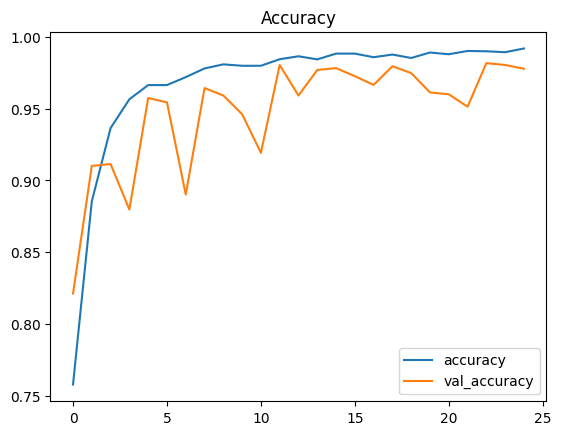

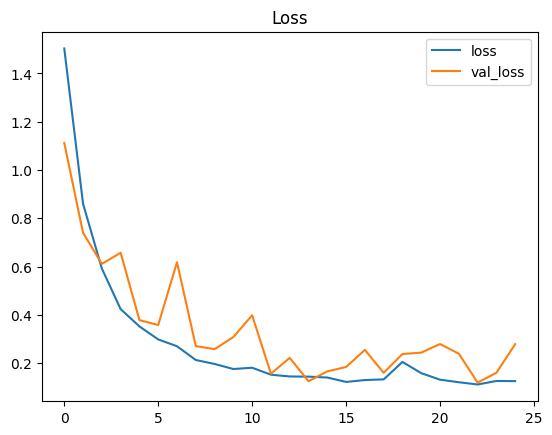

In [ ]:
ef = pd.DataFrame(history.history)
ef[['accuracy', 'val_accuracy']].plot(title="Accuracy")
ef[['loss', 'val_loss']].plot(title="Loss")

In [ ]:
model.evaluate(test)

Actual = []
predictions = []
for images, labels in test:
    Actual.extend(labels.numpy())
    pred = model.predict(images)
    predict = np.argmax(pred, axis=1)
    predictions.extend(predict)

x = classification_report(Actual, predictions, target_names=class_names)
print(x)

72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9797 - loss: 0.1180
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━

Confusion Matrix:
[[546   0   2   0]
 [  0 514   0   0]
 [  7   0 619  14]
 [  3   0  27 572]]


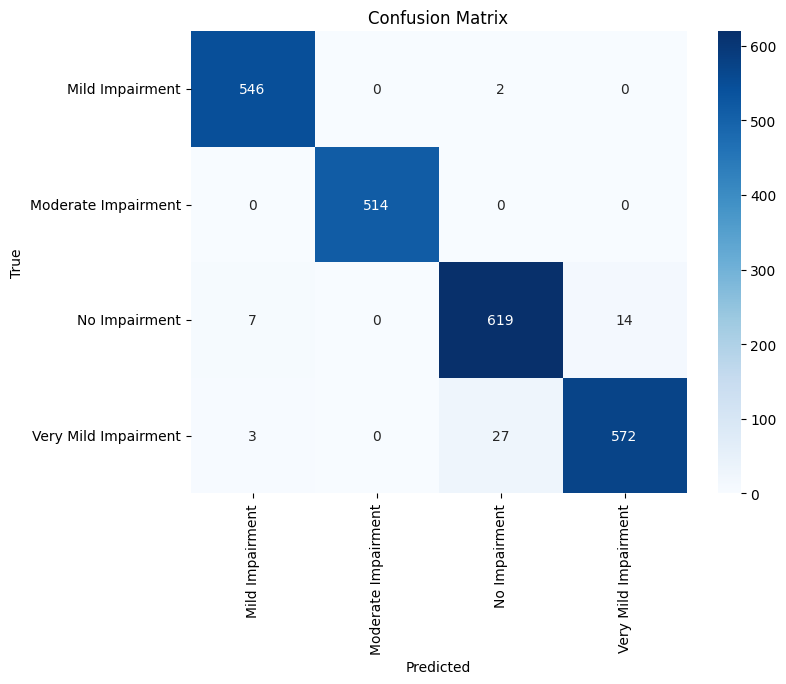

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import os

conf_matrix = confusion_matrix(Actual, predictions)
print("Confusion Matrix:")
print(conf_matrix)

train_path = "./alz_data/Combined Dataset/train"
class_names = sorted(os.listdir(train_path))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


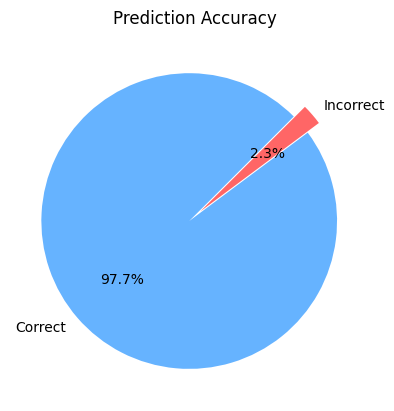

Correct: 2251
Incorrect: 53


In [ ]:
correct = np.trace(conf_matrix)
incorrect = np.sum(conf_matrix) - correct

sizes = [correct, incorrect]
plt.pie(
    sizes,
    labels=["Correct", "Incorrect"],
    autopct="%1.1f%%",
    explode=[0.05, 0.05],
    startangle=45,
    colors=["#66b3ff", "#ff6666"]
)
plt.title("Prediction Accuracy")
plt.show()

print("Correct:", correct)
print("Incorrect:", incorrect)

In [ ]:
history.history['accuracy'][-1], history.history['val_accuracy'][-1]

(0.9919695854187012, 0.9778645634651184)

In [ ]:
model.save("alzheimers_model.keras")


In [ ]:
import tensorflow as tf
import numpy as np
import gradio as gr
from tensorflow.keras.applications.efficientnet import preprocess_input
import nest_asyncio

model = tf.keras.models.load_model("alzheimers_model.keras")

def predict(image):
    img = tf.image.resize(image, (224, 224))
    if img.shape[-1] == 1:
        img = tf.image.grayscale_to_rgb(img)
    img = preprocess_input(img)
    img = tf.expand_dims(img, axis=0)
    preds = model.predict(img)
    class_idx = np.argmax(preds)
    confidence = float(np.max(preds))
    class_names = ["Mild Demented", "Moderate Demented", "Non Demented", "Very Mild Demented"]
    # العودة كـ dict للتوافق مع Gradio
    result = {class_names[class_idx]: confidence}
    return result

interface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="numpy"),
    outputs=gr.Label(num_top_classes=1),
    title="Alzheimer MRI Classifier",
    description="Upload an MRI brain image and get the predicted class."
)

nest_asyncio.apply()
interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://63e3a6cf673a09ff97.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
